# Projet 8 - Déployez un modèle dans le cloud

## Sommaire

In [1]:
import pandas as pd
from PIL import Image
import numpy as np
import io
import os
import seaborn as sns

import tensorflow as tf
from tensorflow.keras.applications.mobilenet_v2 import MobileNetV2, preprocess_input
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras import Model
from pyspark.sql.functions import col, pandas_udf, PandasUDFType, element_at, split
from pyspark.sql import SparkSession

2023-09-23 12:28:51.919077: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
PATH = 's3://oc-calculsdistribues-p8-jkm-rob/'
PATH_Data = PATH+'/data/Test1'
PATH_Result = PATH+'/data/Results'
print('PATH:        '+\
      PATH+'\nPATH_Data:   '+\
      PATH_Data+'\nPATH_Result: '+PATH_Result)

PATH:        /Users/JoycyRobert/Documents/JUPYTER/OPC/PROJET_8/P8
PATH_Data:   /Users/JoycyRobert/Documents/JUPYTER/OPC/PROJET_8/P8/data/Test1
PATH_Result: /Users/JoycyRobert/Documents/JUPYTER/OPC/PROJET_8/P8/data/Results


## Création de la SparkSession

L’application Spark est contrôlée grâce à un processus de pilotage (driver process) appelé **SparkSession**. <br />
<u>Une instance de **SparkSession** est la façon dont Spark exécute les fonctions définies par l’utilisateur <br />
dans l’ensemble du cluster</u>. <u>Une SparkSession correspond toujours à une application Spark</u>.

<u>Ici nous créons une session spark en spécifiant dans l'ordre</u> :
 1. un **nom pour l'application**, qui sera affichée dans l'interface utilisateur Web Spark "**P8**"
 2. que l'application doit s'exécuter **localement**. <br />
   Nous ne définissons pas le nombre de cœurs à utiliser (comme .master('local[4]) pour 4 cœurs à utiliser), <br />
   nous utiliserons donc tous les cœurs disponibles dans notre processeur.<br />
 3. une option de configuration supplémentaire permettant d'utiliser le **format "parquet"** <br />
   que nous utiliserons pour enregistrer et charger le résultat de notre travail.
 4. vouloir **obtenir une session spark** existante ou si aucune n'existe, en créer une nouvelle

In [3]:
spark = (SparkSession
             .builder
             .appName('P8')
             .master('local')
             .config("spark.sql.parquet.writeLegacyFormat", 'true')
             .getOrCreate()
)

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
23/09/19 15:33:16 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [4]:
sc = spark.sparkContext

<u>Affichage des informations de Spark en cours d'execution</u> :

In [5]:
spark

## Traitement des données

<u>Dans la suite de notre flux de travail, <br />
nous allons successivement</u> :
1. Préparer nos données
    1. Importer les images dans un dataframe **pandas UDF**
    2. Associer aux images leur **label**
    3. Préprocesser en **redimensionnant nos images pour <br />
       qu'elles soient compatibles avec notre modèle**
2. Préparer notre modèle
    1. Importer le modèle **MobileNetV2**
    2. Créer un **nouveau modèle** dépourvu de la dernière couche de MobileNetV2
3. Définir le processus de chargement des images et l'application <br />
   de leur featurisation à travers l'utilisation de pandas UDF
3. Exécuter les actions d'extraction de features
4. Enregistrer le résultat de nos actions
5. Tester le bon fonctionnement en chargeant les données enregistrées




### Chargement des données

Les images sont chargées au format binaire, ce qui offre, <br />
plus de souplesse dans la façon de prétraiter les images.

Avant de charger les images, nous spécifions que nous voulons charger <br />
uniquement les fichiers dont l'extension est **jpg**.

Nous indiquons également de charger tous les objets possibles contenus <br />
dans les sous-dossiers du dossier communiqué.

In [6]:
images = spark.read.format("binaryFile") \
  .option("pathGlobFilter", "*.jpg") \
  .option("recursiveFileLookup", "true") \
  .load(PATH_Data)

<u>Affichage des 5 premières images contenant</u> :
 - le path de l'image
 - la date et heure de sa dernière modification
 - sa longueur
 - son contenu encodé en valeur hexadécimal

<u>Je ne conserve que le **path** de l'image et j'ajoute <br />
    une colonne contenant les **labels** de chaque image</u> :

In [7]:
images = images.withColumn('label', element_at(split(images['path'], '/'),-2))
print(images.printSchema())
print(images.select('path','label').show(5,False))

root
 |-- path: string (nullable = true)
 |-- modificationTime: timestamp (nullable = true)
 |-- length: long (nullable = true)
 |-- content: binary (nullable = true)
 |-- label: string (nullable = true)

None
+--------------------------------------------------------------------------------------------------+-------+
|path                                                                                              |label  |
+--------------------------------------------------------------------------------------------------+-------+
|file:/Users/JoycyRobert/Documents/JUPYTER/OPC/PROJET_8/P8/data/Test1/Avocado/r_9_100 17.23.17.jpg |Avocado|
|file:/Users/JoycyRobert/Documents/JUPYTER/OPC/PROJET_8/P8/data/Test1/Avocado/r_8_100 17.23.17.jpg |Avocado|
|file:/Users/JoycyRobert/Documents/JUPYTER/OPC/PROJET_8/P8/data/Test1/Avocado/r_40_100 17.23.17.jpg|Avocado|
|file:/Users/JoycyRobert/Documents/JUPYTER/OPC/PROJET_8/P8/data/Test1/Apricot/r_39_100.jpg         |Apricot|
|file:/Users/JoycyRobert/Do

### Préparation du modèle

Je vais utiliser la technique du **transfert learning** pour extraire les features des images.<br />
J'ai choisi d'utiliser le modèle **MobileNetV2** pour sa rapidité d'exécution comparée <br />
à d'autres modèles comme *VGG16* par exemple.

Pour en savoir plus sur la conception et le fonctionnement de MobileNetV2, <br />
je vous invite à lire [cet article](https://towardsdatascience.com/review-mobilenetv2-light-weight-model-image-classification-8febb490e61c).

<u>Voici le schéma de son architecture globale</u> : 

![Architecture de MobileNetV2](img/mobilenetv2_architecture.png)

Il existe une dernière couche qui sert à classer les images <br />
selon 1000 catégories que nous ne voulons pas utiliser.<br />
L'idée dans ce projet est de récupérer le **vecteur de caractéristiques <br />
de dimensions (1,1,1280)** qui servira, plus tard, au travers d'un moteur <br />
de classification à reconnaitre les différents fruits du jeu de données.

Comme d'autres modèles similaires, **MobileNetV2**, lorsqu'on l'utilise <br />
en incluant toutes ses couches, attend obligatoirement des images <br />
de dimension (224,224,3). Nos images étant toutes de dimension (100,100,3), <br />
nous devrons simplement les **redimensionner** avant de les confier au modèle.

<u>Dans l'odre</u> :
 1. Nous chargeons le modèle **MobileNetV2** avec les poids **précalculés** <br />
    issus d'**imagenet** et en spécifiant le format de nos images en entrée
 2. Nous créons un nouveau modèle avec:
  - <u>en entrée</u> : l'entrée du modèle MobileNetV2
  - <u>en sortie</u> : l'avant dernière couche du modèle MobileNetV2

In [8]:
model = MobileNetV2(weights='imagenet',
                    include_top=True,
                    input_shape=(224, 224, 3))

In [9]:
new_model = Model(inputs=model.input,
                  outputs=model.layers[-2].output)

Affichage du résumé de notre nouveau modèle où nous constatons <br />
que <u>nous récupérons bien en sortie un vecteur de dimension (1, 1, 1280)</u> :

In [10]:
new_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 Conv1 (Conv2D)              (None, 112, 112, 32)         864       ['input_1[0][0]']             
                                                                                                  
 bn_Conv1 (BatchNormalizati  (None, 112, 112, 32)         128       ['Conv1[0][0]']               
 on)                                                                                              
                                                                                                  
 Conv1_relu (ReLU)           (None, 112, 112, 32)         0         ['bn_Conv1[0][0]']        

Tous les workeurs doivent pouvoir accéder au modèle ainsi qu'à ses poids. <br />
Une bonne pratique consiste à charger le modèle sur le driver puis à diffuser <br />
ensuite les poids aux différents workeurs.

In [11]:
brodcast_weights = sc.broadcast(new_model.get_weights())

<u>Mettons cela sous forme de fonction</u> :

In [12]:
def model_fn():
    """
    Returns a MobileNetV2 model with top layer removed 
    and broadcasted pretrained weights.
    """
    model = MobileNetV2(weights='imagenet',
                        include_top=True,
                        input_shape=(224, 224, 3))
    for layer in model.layers:
        layer.trainable = False
    new_model = Model(inputs=model.input,
                  outputs=model.layers[-2].output)
    new_model.set_weights(brodcast_weights.value)
    return new_model

### Définition du processus de chargement des images et application <br/>de leur featurisation à travers l'utilisation de pandas UDF

Ce notebook définit la logique par étapes, jusqu'à Pandas UDF.

<u>L'empilement des appels est la suivante</u> :

- Pandas UDF
  - featuriser une série d'images pd.Series
   - prétraiter une image

In [13]:
def preprocess(content):
    """
    Preprocesses raw image bytes for prediction.
    """
    img = Image.open(io.BytesIO(content)).resize([224, 224])
    arr = img_to_array(img)
    return preprocess_input(arr)

def featurize_series(model, content_series):
    """
    Featurize a pd.Series of raw images using the input model.
    :return: a pd.Series of image features
    """
    input = np.stack(content_series.map(preprocess))
    preds = model.predict(input)
    # For some layers, output features will be multi-dimensional tensors.
    # We flatten the feature tensors to vectors for easier storage in Spark DataFrames.
    output = [p.flatten() for p in preds]
    return pd.Series(output)

@pandas_udf('array<float>', PandasUDFType.SCALAR_ITER)
def featurize_udf(content_series_iter):
    '''
    This method is a Scalar Iterator pandas UDF wrapping our featurization function.
    The decorator specifies that this returns a Spark DataFrame column of type ArrayType(FloatType).

    :param content_series_iter: This argument is an iterator over batches of data, where each batch
                              is a pandas Series of image data.
    '''
    # With Scalar Iterator pandas UDFs, we can load the model once and then re-use it
    # for multiple data batches.  This amortizes the overhead of loading big models.
    model = model_fn()
    for content_series in content_series_iter:
        yield featurize_series(model, content_series)

/Users/JoycyRobert/Documents/JUPYTER/OPC/PROJET_8/P8/venv_P8/lib/python3.9/site-packages/pyspark/sql/pandas/functions.py:399: UserWarning: In Python 3.6+ and Spark 3.0+, it is preferred to specify type hints for pandas UDF instead of specifying pandas UDF type which will be deprecated in the future releases. See SPARK-28264 for more details.
  warnings.warn(


### 3.7.4 Exécution des actions d'extraction de features

Les Pandas UDF, sur de grands enregistrements (par exemple, de très grandes images), <br />
peuvent rencontrer des erreurs de type Out Of Memory (OOM).<br />
Si vous rencontrez de telles erreurs dans la cellule ci-dessous, <br />
essayez de réduire la taille du lot Arrow via 'maxRecordsPerBatch'

Je n'utiliserai pas cette commande dans ce projet <br />
et je laisse donc la commande en commentaire.

In [14]:
# spark.conf.set("spark.sql.execution.arrow.maxRecordsPerBatch", "1024")

Nous pouvons maintenant exécuter la featurisation sur l'ensemble de notre DataFrame Spark.<br />
<u>REMARQUE</u> : Cela peut prendre beaucoup de temps, tout dépend du volume de données à traiter. <br />

Notre jeu de données de **Test** contient **22819 images**. <br />
Cependant, dans l'exécution en mode **local**, <br />
nous <u>traiterons un ensemble réduit de **330 images**</u>.

In [15]:
features_df = images.repartition(10).select(col("path"),
                                            col("label"),
                                            featurize_udf("content").alias("features")
                                           )

<u>Rappel du PATH où seront inscrits les fichiers au format "**parquet**" <br />
contenant nos résultats, à savoir, un DataFrame contenant 3 colonnes</u> :
 1. Path des images
 2. Label de l'image
 3. Vecteur de caractéristiques de l'image

In [16]:
print(PATH_Result)

/Users/JoycyRobert/Documents/JUPYTER/OPC/PROJET_8/P8/data/Results


<u>Enregistrement des données traitées au format "**parquet**"</u> :

In [17]:
features_df.write.mode("overwrite").parquet(PATH_Result)

2023-09-19 15:33:37.716365: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
1/1 [==============================] - 1s 1s/step============>     (9 + 1) / 10]


## Chargement des données enregistrées et validation du résultat

<u>On charge les données fraichement enregistrées dans un **DataFrame Pandas**</u> :

In [18]:
df = pd.read_parquet(PATH_Result, engine='pyarrow')

<u>On affiche les 5 premières lignes du DataFrame</u> :

In [19]:
df.head()

,path,label,features
0,file:/Users/JoycyRobert/Documents/JUPYTER/OPC/...,Apricot,"[0.9467754, 0.5196316, 0.0, 0.010057771, 0.016..."
1,file:/Users/JoycyRobert/Documents/JUPYTER/OPC/...,Banana,"[0.26353976, 0.0, 0.0, 0.0, 1.0935742, 0.02494..."
2,file:/Users/JoycyRobert/Documents/JUPYTER/OPC/...,Avocado,"[1.3703408, 0.0, 0.30703285, 0.0, 0.0, 0.23501..."
3,file:/Users/JoycyRobert/Documents/JUPYTER/OPC/...,Apricot,"[0.55438334, 0.03335581, 0.0, 0.0, 0.1443844, ..."
4,file:/Users/JoycyRobert/Documents/JUPYTER/OPC/...,Apricot,"[1.0993195, 0.00024267119, 0.0, 0.0, 0.0863437..."


<u>On valide que la dimension du vecteur de caractéristiques des images est bien de dimension 1280</u> :

In [20]:
df.loc[0,'features'].shape

(1280,)

In [21]:
df.shape

(28, 3)

Nous venons de valider le processus sur un jeu de données allégé en local <br />
où nous avons simulé un cluster de machines en répartissant la charge de travail <br />
sur différents cœurs de processeur au sein d'une même machine.

Nous allons maintenant généraliser le processus en déployant notre solution <br />
sur un réel cluster de machines et nous travaillerons désormais sur la totalité <br />
des 22819 images de notre dossier "Test".

## Analyse en composantes principales 

In [22]:
from pyspark.sql import SparkSession
from pyspark.ml.feature import PCA
from pyspark.ml.linalg import Vectors
from pyspark.ml.feature import VectorAssembler
from pyspark.sql.functions import col
from pyspark.sql.types import ArrayType, DoubleType, StringType

In [23]:
df.columns

Index(['path', 'label', 'features'], dtype='object')

In [24]:
df['features'][0]

array([0.9467754 , 0.5196316 , 0.        , ..., 0.07286832, 0.        ,
       0.        ], dtype=float32)

In [25]:
features_df.printSchema()

root
 |-- path: string (nullable = true)
 |-- label: string (nullable = true)
 |-- features: array (nullable = true)
 |    |-- element: float (containsNull = true)



In [26]:
features_df.columns

['path', 'label', 'features']

In [27]:
#  Example from pyspark documentation 

from pyspark.ml.linalg import Vectors
data_ex = [(Vectors.sparse(5, [(1, 1.0), (3, 7.0)]),),
    (Vectors.dense([2.0, 0.0, 3.0, 4.0, 5.0]),),
    (Vectors.dense([4.0, 0.0, 0.0, 6.0, 7.0]),)]
df_ex = spark.createDataFrame(data_ex,["features"])

In [28]:
df_ex.show()

+--------------------+
|            features|
+--------------------+
| (5,[1,3],[1.0,7.0])|
|[2.0,0.0,3.0,4.0,...|
|[4.0,0.0,0.0,6.0,...|
+--------------------+



In [29]:
features_df.show()

1/1 [==============================] - 1s 921ms/step                (1 + 1) / 3]


+--------------------+-------+--------------------+
|                path|  label|            features|
+--------------------+-------+--------------------+
|file:/Users/Joycy...|Apricot|[0.9467754, 0.519...|
|file:/Users/Joycy...| Banana|[0.26353976, 0.0,...|
|file:/Users/Joycy...|Avocado|[1.3703408, 0.0, ...|
|file:/Users/Joycy...|Apricot|[0.55438334, 0.03...|
|file:/Users/Joycy...|Apricot|[1.0993195, 2.426...|
|file:/Users/Joycy...|Avocado|[0.37964696, 0.0,...|
|file:/Users/Joycy...| Banana|[1.1546928, 0.064...|
|file:/Users/Joycy...| Banana|[1.8319335, 0.0, ...|
|file:/Users/Joycy...| Banana|[1.237112, 0.1186...|
|file:/Users/Joycy...|Apricot|[0.89959294, 0.0,...|
|file:/Users/Joycy...|Apricot|[0.9467928, 0.061...|
|file:/Users/Joycy...| Banana|[0.04606829, 0.04...|
|file:/Users/Joycy...| Banana|[0.028012188, 0.0...|
|file:/Users/Joycy...|Apricot|[0.7736844, 0.042...|
|file:/Users/Joycy...| Banana|[1.2731441, 0.075...|
|file:/Users/Joycy...| Banana|[1.2445862, 0.066...|
|file:/Users

1/1 [==============================] - 1s 1s/step


In [30]:
features_df.first()

1/1 [==============================] - 1s 1s/step                   (0 + 1) / 1]


Row(path='file:/Users/JoycyRobert/Documents/JUPYTER/OPC/PROJET_8/P8/data/Test1/Apricot/90_100.jpg', label='Apricot', features=[0.9467743635177612, 0.5196321606636047, 0.0, 0.010057352483272552, 0.016932876780629158, 0.14489887654781342, 0.28260236978530884, 0.036334194242954254, 0.7007402181625366, 0.27605345845222473, 0.20499014854431152, 0.3174382746219635, 0.08214661478996277, 0.0, 0.003290001302957535, 0.5765994191169739, 0.0, 0.011557277292013168, 0.12357444316148758, 0.1446794718503952, 0.0, 0.21958962082862854, 0.0, 0.1127864196896553, 0.0, 0.0, 0.012632311321794987, 0.087211012840271, 0.0, 0.009029855951666832, 0.0, 0.0, 0.0, 0.10818367451429367, 0.0, 0.026793217286467552, 2.773812770843506, 1.4509016275405884, 0.47576063871383667, 0.0, 0.06348806619644165, 0.0, 0.3379289209842682, 0.086782306432724, 0.0, 0.0, 1.0656020641326904, 1.5054692029953003, 0.5794548988342285, 0.18621283769607544, 0.08606820553541183, 0.2312014251947403, 0.0, 0.0, 0.011017478071153164, 2.04066085815429

In [31]:
from pyspark.ml.feature import PCA
from pyspark.sql.functions import udf
from pyspark.ml.linalg import Vectors, VectorUDT

# Define a UDF to convert the array<float> to VectorUDT
array_to_vector_udf = udf(lambda arr: Vectors.dense(arr), VectorUDT())
# Assuming 'features_df' is your PySpark DataFrame
# Apply the UDF to create a new column of type VectorUDT
features_df = features_df.withColumn("features_vector", array_to_vector_udf(features_df["features"]))

In [32]:
features_df.show()

2023-09-19 15:34:42.689361: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
1/1 [==============================] - 1s 1s/step                   (1 + 1) / 3]


+--------------------+-------+--------------------+--------------------+
|                path|  label|            features|     features_vector|
+--------------------+-------+--------------------+--------------------+
|file:/Users/Joycy...|Apricot|[0.9467754, 0.519...|[0.94677537679672...|
|file:/Users/Joycy...| Banana|[0.26353976, 0.0,...|[0.26353976130485...|
|file:/Users/Joycy...|Avocado|[1.3703408, 0.0, ...|[1.37034082412719...|
|file:/Users/Joycy...|Apricot|[0.55438334, 0.03...|[0.55438333749771...|
|file:/Users/Joycy...|Apricot|[1.0993195, 2.426...|[1.09931945800781...|
|file:/Users/Joycy...|Avocado|[0.37964696, 0.0,...|[0.37964695692062...|
|file:/Users/Joycy...| Banana|[1.1546928, 0.064...|[1.15469276905059...|
|file:/Users/Joycy...| Banana|[1.8319335, 0.0, ...|[1.83193349838256...|
|file:/Users/Joycy...| Banana|[1.237112, 0.1186...|[1.23711204528808...|
|file:/Users/Joycy...|Apricot|[0.89959294, 0.0,...|[0.89959293603897...|
|file:/Users/Joycy...|Apricot|[0.9467928, 0.061...|

1/1 [==============================] - 1s 962ms/step


In [33]:
from pyspark.ml.feature import PCA

# Assuming 'features_df' is your PySpark DataFrame
num_components = 128 
pca = PCA(k=num_components, inputCol='features_vector', outputCol='pca_features')
pca_model = pca.fit(features_df)
result_df = pca_model.transform(features_df)

1/1 [==============================] - 1s 1s/step                  (0 + 1) / 10]
23/09/19 15:35:52 WARN InstanceBuilder: Failed to load implementation from:dev.ludovic.netlib.blas.JNIBLAS
1/1 [==============================] - 1s 988ms/step=========>     (9 + 1) / 10]
23/09/19 15:36:20 WARN InstanceBuilder: Failed to load implementation from:dev.ludovic.netlib.lapack.JNILAPACK


In [34]:
result_df.show()

23/09/19 15:36:31 WARN DAGScheduler: Broadcasting large task binary with size 1333.8 KiB
1/1 [==============================] - 1s 999ms/step                (0 + 1) / 1]
23/09/19 15:36:34 WARN DAGScheduler: Broadcasting large task binary with size 1333.8 KiB
1/1 [==============================] - 1s 1s/step====>              (3 + 1) / 4]
23/09/19 15:36:45 WARN DAGScheduler: Broadcasting large task binary with size 1333.8 KiB
1/1 [==============================] - 1s 1s/step                   (1 + 1) / 3]


+--------------------+-------+--------------------+--------------------+--------------------+
|                path|  label|            features|     features_vector|        pca_features|
+--------------------+-------+--------------------+--------------------+--------------------+
|file:/Users/Joycy...|Apricot|[0.9467754, 0.519...|[0.94677537679672...|[6.79887916437619...|
|file:/Users/Joycy...| Banana|[0.26353976, 0.0,...|[0.26353976130485...|[-9.0094289489083...|
|file:/Users/Joycy...|Avocado|[1.3703408, 0.0, ...|[1.37034082412719...|[18.9092465021739...|
|file:/Users/Joycy...|Apricot|[0.55438334, 0.03...|[0.55438333749771...|[6.76420927110187...|
|file:/Users/Joycy...|Apricot|[1.0993195, 2.426...|[1.09931945800781...|[5.81041076587230...|
|file:/Users/Joycy...|Avocado|[0.37964696, 0.0,...|[0.37964695692062...|[12.8023063381090...|
|file:/Users/Joycy...| Banana|[1.1546928, 0.064...|[1.15469276905059...|[-7.0325937113686...|
|file:/Users/Joycy...| Banana|[1.8319335, 0.0, ...|[1.831933

1/1 [==============================] - 1s 1s/step


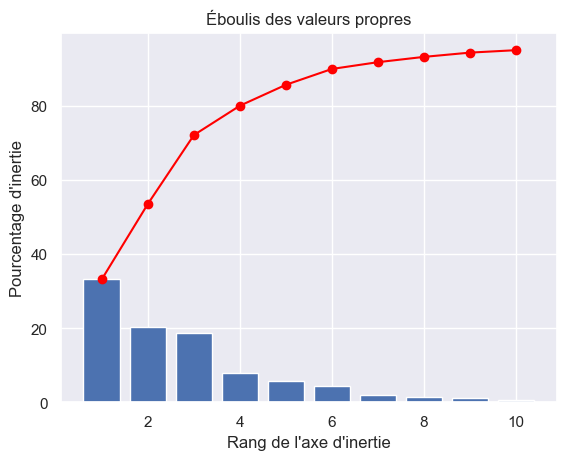

In [35]:
import matplotlib.pyplot as plt
from pyspark.sql import functions as F
from pyspark.sql.functions import col

# Assuming 'result_df' contains the PCA-transformed features and labels
# Calculate the explained variance ratio for each principal component
# Assuming 'explained_variance' contains the explained variance for each principal component
explained_variance = pca_model.explainedVariance.toArray()  # Convert to a NumPy array
scree = (explained_variance*100).round(2) 
# Calculate the cumulative explained variance
scree_cum = np.cumsum(scree)

x_list = range(1, len(scree[:10])+1)
list(x_list)
sns.set()
fig = plt.bar(x_list, scree[:10])
plt.plot(x_list, scree_cum[:10],c="red",marker='o')
plt.xlabel("Rang de l'axe d'inertie")
plt.ylabel("Pourcentage d'inertie")
plt.title("Éboulis des valeurs propres")

# Show the combined plot
plt.show()
plt.savefig('s3://oc-calculsdistribues-p8-jkm-rob/data/Results/eboulis_valeurs.png')

In [36]:
explained_variance

array([3.32214937e-01, 2.03272213e-01, 1.85784770e-01, 7.91622890e-02,
       5.65393237e-02, 4.26651645e-02, 1.83367788e-02, 1.43128131e-02,
       1.14590287e-02, 6.64433052e-03, 5.93088444e-03, 5.07380776e-03,
       4.93202428e-03, 4.72849000e-03, 4.22098094e-03, 3.86771036e-03,
       3.33959139e-03, 3.03673054e-03, 2.80317932e-03, 2.31473086e-03,
       1.99677048e-03, 1.85298336e-03, 1.81776436e-03, 1.20683054e-03,
       9.87017451e-04, 7.79550782e-04, 7.19304986e-04, 6.22497986e-16,
       4.60719484e-16, 3.27708863e-16, 3.05272172e-16, 2.76327696e-16,
       2.15134346e-16, 1.85228515e-16, 1.50020712e-16, 1.41455878e-16,
       1.34494033e-16, 1.16676948e-16, 1.15176996e-16, 1.05548917e-16,
       9.96579734e-17, 9.08411986e-17, 7.28088095e-17, 7.05159259e-17,
       6.59510798e-17, 5.91199054e-17, 5.70598967e-17, 5.02425334e-17,
       4.90959154e-17, 3.42438524e-17, 3.01443110e-17, 2.81454675e-17,
       2.81454675e-17, 2.81454675e-17, 2.81454675e-17, 2.81454675e-17,
      

In [37]:
pandas_df = result_df.toPandas()

23/09/19 15:36:55 WARN DAGScheduler: Broadcasting large task binary with size 1336.3 KiB
1/1 [==============================] - 1s 990ms/step=========>     (9 + 1) / 10]


In [38]:
pandas_df

,path,label,features,features_vector,pca_features
0,file:/Users/JoycyRobert/Documents/JUPYTER/OPC/...,Apricot,"[0.9467753767967224, 0.5196316242218018, 0.0, ...","[0.9467753767967224, 0.5196316242218018, 0.0, ...","[6.7988791643761965, 10.920687564667348, 1.683..."
1,file:/Users/JoycyRobert/Documents/JUPYTER/OPC/...,Banana,"[0.26353976130485535, 0.0, 0.0, 0.0, 1.0935741...","[0.26353976130485535, 0.0, 0.0, 0.0, 1.0935741...","[-9.009428948908393, -8.870745974058526, -8.83..."
2,file:/Users/JoycyRobert/Documents/JUPYTER/OPC/...,Avocado,"[1.3703408241271973, 0.0, 0.30703285336494446,...","[1.3703408241271973, 0.0, 0.30703285336494446,...","[18.909246502173954, -6.270296867198722, 8.251..."
3,file:/Users/JoycyRobert/Documents/JUPYTER/OPC/...,Apricot,"[0.5543833374977112, 0.03335580974817276, 0.0,...","[0.5543833374977112, 0.03335580974817276, 0.0,...","[6.764209271101875, 10.948024457083177, 0.4819..."
4,file:/Users/JoycyRobert/Documents/JUPYTER/OPC/...,Apricot,"[1.0993194580078125, 0.00024267118715215474, 0...","[1.0993194580078125, 0.00024267118715215474, 0...","[5.810410765872303, 12.76565378088618, -0.2282..."
5,file:/Users/JoycyRobert/Documents/JUPYTER/OPC/...,Avocado,"[0.3796469569206238, 0.0, 0.26109811663627625,...","[0.3796469569206238, 0.0, 0.26109811663627625,...","[12.802306338109057, -4.563962920450023, 3.464..."
6,file:/Users/JoycyRobert/Documents/JUPYTER/OPC/...,Banana,"[1.1546927690505981, 0.0642751157283783, 0.205...","[1.1546927690505981, 0.0642751157283783, 0.205...","[-7.032593711368696, 0.3082073668165733, 14.72..."
7,file:/Users/JoycyRobert/Documents/JUPYTER/OPC/...,Banana,"[1.8319334983825684, 0.0, 0.0, 0.0101655256003...","[1.8319334983825684, 0.0, 0.0, 0.0101655256003...","[-4.941663469268065, 1.1196422167182878, 9.381..."
8,file:/Users/JoycyRobert/Documents/JUPYTER/OPC/...,Banana,"[1.237112045288086, 0.11860422044992447, 0.0, ...","[1.237112045288086, 0.11860422044992447, 0.0, ...","[-7.124846409115405, 0.5035853297239603, 13.58..."
9,file:/Users/JoycyRobert/Documents/JUPYTER/OPC/...,Apricot,"[0.899592936038971, 0.0, 0.0, 0.0, 0.037708349...","[0.899592936038971, 0.0, 0.0, 0.0, 0.037708349...","[5.998582237932294, 12.642519060379511, -0.558..."


In [42]:
# Extract the PCA components (the first two)
for j in range(6):
    feat_name = 'pca'+str(j+1)
    pandas_df[feat_name] = pandas_df['pca_features'].apply(lambda x: x[j])

<Axes: xlabel='pca_1', ylabel='pca_2'>

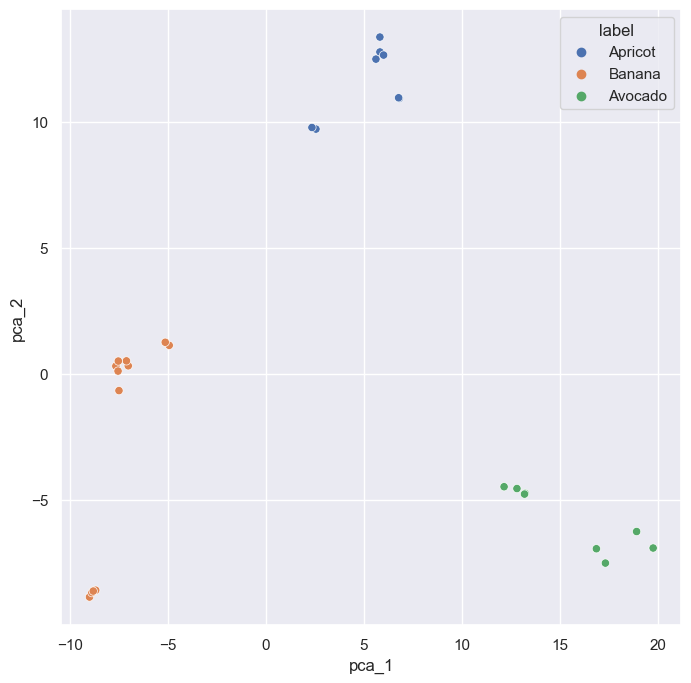

In [40]:
sns.set()
fig, ax = plt.subplots(figsize= (8,8))
sns.scatterplot(data = pandas_df, x = 'pca_1', y = 'pca_2', hue = 'label')
plt.savefig('s3://oc-calculsdistribues-p8-jkm-rob/data/Results/PCA_plan_principale_1.png')


In [44]:
pandas_df = pandas_df.drop(columns =['features', 'features_vector', 'pca_features'])
pandas_df.head()

In [46]:
pandas_df.to_csv('s3://oc-calculsdistribues-p8-jkm-rob/data/Results/KuohMoukouri_Joyce_4_matrice_092023.csv')